In [1]:
import os
os.chdir('/Users/poojamangal/Desktop/Masters/NNProject/')


In [2]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from models.alexNet_fineTuner import AlexNetFineTuner
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score 
from torchmetrics.functional import accuracy
import os


In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (AlexNet input size)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize with ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [4]:
# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into train/validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
# pruning_percentages = [0.1, 0.3, 0.5]
pruning_percentages = [0.5]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, dataloader):
    """
    Evaluates the model and returns the accuracy and F1 score.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Append predictions and labels to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return accuracy, f1


# Fine-tune model function
def fine_tune_model(model, train_dataloader, val_dataloader, epochs=5, learning_rate=1e-5):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0

        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation loop
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_acc = train_correct / len(train_dataloader.dataset)
        val_acc = val_correct / len(val_dataloader.dataset)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model

# Visualize weights function
def visualize_weights(weights, title, save_path="./plots", name="weights.png"):
    out_channels, in_channels, height, width = weights.shape
    n_cols = min(8, out_channels)  # Set the number of columns
    n_rows = (out_channels + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(title, fontsize=16)
    for i in range(out_channels):
        kernel = weights[i, 0].cpu().detach().numpy()
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]
        ax.imshow(kernel, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Filter {i}")
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])
    plt.tight_layout()
    plt.savefig(f"{save_path}/{name}")
    print(f"Pruned weights visualization saved: {save_path}/{name}")

# Get non-zero indices function
def get_nonzero_indices(model):
    non_zero_indices = {}
    new_channels = {}
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weights = module.weight.data
            indices = [i for i in range(weights.size(0)) if weights[i].abs().sum() > 0]
            normalized_name = name.replace('model.', '')
            non_zero_indices[normalized_name] = indices
            out_channels = len(indices)
            in_channels = weights.size(1) if len(weights.shape) > 2 else weights.shape[0]
            new_channels[normalized_name] = (out_channels, in_channels)
    return non_zero_indices, new_channels

# Create dense model function
def create_dense_model(new_channels):
    class DenseAlexNet(nn.Module):
        def __init__(self):
            super(DenseAlexNet, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, new_channels["features.0"][0], kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(new_channels["features.0"][0], new_channels["features.3"][0], kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(new_channels["features.3"][0], new_channels["features.6"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(new_channels["features.6"][0], new_channels["features.8"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(new_channels["features.8"][0], new_channels["features.10"][0], kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
            self.classifier = nn.Sequential(
                nn.Linear(new_channels["features.10"][0] * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 10),
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x
    return DenseAlexNet()

# Function to copy weights from pruned to dense model
def copy_weights(pruned_model, dense_model, non_zero_indices):
    for (name, module), (_, dense_module) in zip(pruned_model.named_modules(), dense_model.named_modules()):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if name in non_zero_indices:
                indices = non_zero_indices[name]
                for idx_out, idx_in in indices:
                    dense_module.weight.data[idx_out].copy_(module.weight.data[idx_out])
                if module.bias is not None:
                    dense_module.bias.data.copy_(module.bias.data)

# Plotting results
def plot_comparison(val_accuracy, val_f1_score, fine_tune_accuracy, fine_tune_f1_score, exp_name, prune_ratio):
    plt.figure(figsize=(8, 4))
    plt.bar(['Accuracy Before', 'F1 Score Before', 'Accuracy After', 'F1 Score After'],
            [val_accuracy, val_f1_score, fine_tune_accuracy, fine_tune_f1_score],
            color=['skyblue', 'salmon', 'skyblue', 'salmon'])
    plt.ylabel("Score")
    plt.title(f"Evaluation Metrics Before and After Fine-Tuning (Prune Ratio: {prune_ratio*100:.0f}%)")
    os.makedirs("./plots", exist_ok=True)
    plt.savefig(f"./plots/{exp_name}_Accuracy_Comparison_{str(int(prune_ratio*100))}.png")
    plt.show()

def get_pruned_indices_and_counts(model):
    """
    Analyze a structurally pruned model to determine:
    - The indices of pruned channels (dim 0 and dim 1).
    - The number of pruned channels in each layer.
    
    Parameters:
    - model: The PyTorch model.

    Returns:
    - pruned_info: A dictionary containing pruned indices and counts for each layer.
    """
    pruned_info = {}
    pruned_weights = {}
    num_pruned_channels = {}
    
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):  # Check for Conv2d layers
            layer_info = {}
            
            # Get the weight tensor
            weights = layer.weight.detach()
            print("LAYER----------", layer)
            print("LAYER.weight----------", layer.weight)
            print("LAYER.weight.detach----------", layer.weight.detach)
            
            # Identify pruned filters along dim=0 (output channels)
            pruned_dim0 = torch.nonzero(weights.abs().sum(dim=(1, 2, 3)) == 0).squeeze().tolist()
            if isinstance(pruned_dim0, int):  # Handle single index case
                pruned_dim0 = [pruned_dim0]
            layer_info['pruned_dim0'] = pruned_dim0
            
            
            # Identify pruned filters along dim=1 (input channels)
            pruned_dim1 = torch.nonzero(weights.abs().sum(dim=(0, 2, 3)) == 0).squeeze().tolist()
            if isinstance(pruned_dim1, int):  # Handle single index case
                pruned_dim1 = [pruned_dim1]
            layer_info['pruned_dim1'] = pruned_dim1
            
            # Add layer information to pruned_info
            pruned_info[name] = layer_info
            num_pruned_channels[name] = (len(pruned_dim0), len(pruned_dim1))
            
            pruned_weights[name] = weights[pruned_dim0][:,pruned_dim1,:,:]
    
    return pruned_info, num_pruned_channels, pruned_weights

def get_unpruned_indices_and_counts(model):
    non_pruned_info = {}
    num_unpruned_channels = {}
    unpruned_weights = {}
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            
            layer_info = {}
            
            # Get the weight tensor
            weights = module.weight.detach()
            
            # Identify pruned filters along dim=0 (output channels)
            pruned_dim0 = torch.nonzero(weights.abs().sum(dim=(1, 2, 3)) > 0).squeeze().tolist()
            if isinstance(pruned_dim0, int):  # Handle single index case
                pruned_dim0 = [pruned_dim0]
            layer_info['pruned_dim0'] = pruned_dim0
            
            
            # Identify pruned filters along dim=1 (input channels)
            pruned_dim1 = torch.nonzero(weights.abs().sum(dim=(0, 2, 3)) > 0).squeeze().tolist()
            if isinstance(pruned_dim1, int):  # Handle single index case
                pruned_dim1 = [pruned_dim1]
            layer_info['pruned_dim1'] = pruned_dim1
        
            non_pruned_info[name] = layer_info
            num_unpruned_channels[name] = (len(pruned_dim0), len(pruned_dim1))
            unpruned_weights[name] = weights[pruned_dim0][:,pruned_dim1,:,:]
                            
                        
    return non_pruned_info, num_unpruned_channels, unpruned_weights

    
def count_zero_weights(model):
    total_weights = 0
    zero_weights = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_weights += param.numel()
            zero_weights += (param == 0).sum().item()
    print(f"Total weights: {total_weights}")
    print(f"Zero weights: {zero_weights}")
    print(f"Percentage of pruned weights: {100 * zero_weights / total_weights:.2f}%")


    



In [6]:
accuracies = []
f1_scores = []

for amount in pruning_percentages:
    checkpoint_path = "checkpoints/best_checkpoint.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path).to(device)

     # Evaluate the model before pruning
    # orig_accuracy, orig_f1_score = evaluate_model(model, test_dataloader)
    # print(f"Original Accuracy before pruning: {orig_accuracy:.4f}")
    # print(f"Original F1 Score before pruning: {orig_f1_score:.4f}")

    if amount > 0:
        parameters_to_prune = [(module, 'weight') for name, module in model.named_modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount)
    
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

    count_zero_weights(model)
    nonzero , new_channels = get_nonzero_indices(model)
    
    pruned_info, num_pruned_channels, pruned_weights = get_pruned_indices_and_counts(model)
    non_pruned_info, num_unpruned_channels, unpruned_weights = get_unpruned_indices_and_counts(model)

    # print(f"Fine-tuning the model after pruning {amount * 100:.0f}% of weights...")
    # fine_tune_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=1e-5)

    # Evaluate the fine-tuned model
    # fine_tuned_accuracy, fine_tuned_f1_score = evaluate_model(model, test_dataloader)
    # print(f"Fine-tuned Accuracy after pruning {amount * 100:.0f}%: {fine_tuned_accuracy:.4f}")
    # print(f"Fine-tuned F1 Score after pruning {amount * 100:.0f}%: {fine_tuned_f1_score:.4f}")
    
    # Store accuracies and F1 scores for plotting
    # accuracies.append((orig_accuracy, fine_tuned_accuracy))
    # f1_scores.append((orig_f1_score, fine_tuned_f1_score))
    
    # non_zero_indices, new_channels = get_nonzero_indices(model)
    
    # for name, module in model.named_modules():
    #     if isinstance(module, nn.Conv2d):
    #         visualize_weights(module.weight, f"Pruned Weights in {name}", name=f"{name.replace('.', '_')}_pruned_weights.png")
    
    # dense_model = create_dense_model(new_channels)
    # copy_weights(model, dense_model, non_zero_indices)

   # Verify the dense model
    # print("Original Model:", model)
    # print("Dense Model:", dense_model)
    # print(f"Pruning {amount * 100:.0f}% Complete!")

    # Plot comparison of accuracy and F1 score before and after fine-tuning
    # plot_comparison(
    #     val_accuracy=orig_accuracy,
    #     val_f1_score=orig_f1_score,
    #     fine_tune_accuracy=fine_tuned_accuracy,
    #     fine_tune_f1_score=fine_tuned_f1_score,
    #     exp_name=f"Pruning_{amount * 100:.0f}",
    #     prune_ratio=amount
    # )

/Users/poojamangal/Desktop/Masters/NNProject/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/poojamangal/Desktop/Masters/NNProject/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total weights: 57035456
Zero weights: 28517728
Percentage of pruned weights: 50.00%


TypeError: get_pruned_indices_and_counts() takes 0 positional arguments but 1 was given

In [7]:
print(pruned_weights)

{'model.features.0': tensor([], size=(0, 0, 11, 11)), 'model.features.3': tensor([], size=(0, 0, 5, 5)), 'model.features.6': tensor([], size=(0, 0, 3, 3)), 'model.features.8': tensor([], size=(0, 0, 3, 3)), 'model.features.10': tensor([], size=(0, 0, 3, 3))}


In [8]:
print(num_pruned_channels)

{'model.features.0': (0, 0), 'model.features.3': (0, 0), 'model.features.6': (0, 0), 'model.features.8': (0, 0), 'model.features.10': (0, 0)}


In [9]:
print(pruned_info)

{'model.features.0': {'pruned_dim0': [], 'pruned_dim1': []}, 'model.features.3': {'pruned_dim0': [], 'pruned_dim1': []}, 'model.features.6': {'pruned_dim0': [], 'pruned_dim1': []}, 'model.features.8': {'pruned_dim0': [], 'pruned_dim1': []}, 'model.features.10': {'pruned_dim0': [], 'pruned_dim1': []}}


In [15]:
print(non_pruned_info)

{'model.features.0': {'pruned_dim0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], 'pruned_dim1': [0, 1, 2]}, 'model.features.3': {'pruned_dim0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 1

In [12]:
num_unpruned_channels

{'model.features.0': (64, 3),
 'model.features.3': (192, 64),
 'model.features.6': (384, 192),
 'model.features.8': (256, 384),
 'model.features.10': (256, 256)}

In [14]:
unpruned_weights

{'model.features.0': tensor([[[[ 0.0401,  0.0000,  0.0401,  ..., -0.0290,  0.0119, -0.0238],
           [ 0.0195, -0.0310, -0.0540,  ..., -0.0208, -0.0000,  0.0247],
           [-0.0455,  0.0484,  0.0283,  ...,  0.0000, -0.0515, -0.0482],
           ...,
           [-0.0258,  0.0305,  0.0299,  ...,  0.0000, -0.0327, -0.0457],
           [ 0.0233, -0.0344, -0.0374,  ..., -0.0411,  0.0206, -0.0000],
           [-0.0120, -0.0535,  0.0259,  ..., -0.0479, -0.0435, -0.0219]],
 
          [[-0.0098, -0.0191, -0.0277,  ...,  0.0357,  0.0114,  0.0448],
           [-0.0123, -0.0401,  0.0416,  ...,  0.0286, -0.0185, -0.0408],
           [-0.0068, -0.0236,  0.0289,  ..., -0.0082, -0.0420,  0.0137],
           ...,
           [ 0.0369,  0.0195, -0.0195,  ...,  0.0403,  0.0275, -0.0496],
           [ 0.0266, -0.0514,  0.0137,  ..., -0.0294,  0.0382,  0.0308],
           [-0.0393,  0.0282,  0.0136,  ..., -0.0216, -0.0437,  0.0314]],
 
          [[-0.0334, -0.0000,  0.0518,  ...,  0.0374,  0.0082,  0.

In [10]:
print("Accuracy for global unstructured", accuracies)

Accuracy for global unstructured []


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

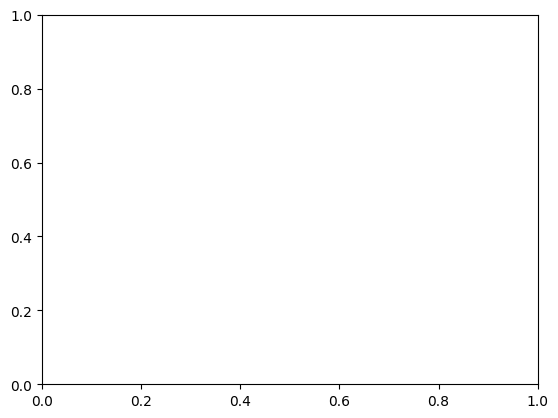

In [11]:
# Plot accuracy vs. pruning percentage
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()